Quick Drawing is a kaggle challenge for classifying the sketch pictures. The total number of category is 340 and 
there are 50M pictures in the dataset. Each catogory has 25,000 pictures. The difficulty is the drawing might be 
incomplete or the drawing does not match the label. We are trying to develop a CNN to solve the issue.   

According to the challenge, there are 4 kinds of dataset. 

    - Raw data (.ndjson)
    - Simplified drawings (.ndjson)
    - Binary data (.bin)
    - Bitmap data (.npy)
Raw data and Simplified drawings are provided in a vector information of strokes. Bitmap data is rendered into 
28 * 28 grayscale bitmap in the numpy format.  

Maybe we could consider the raw data to improve the performance since it inlcudes the sequence information.


In [3]:
import torch
import time
import torch
import os
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import numpy as np
from torch.utils import data
import QDdata as QD
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader
import resnet as RN
from torchvision import transforms
import csv

In [4]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 300

print('using device:', device)


using device: cuda


# Data Augmentation

In [5]:
trans = transforms.Compose([transforms.RandomHorizontalFlip(0.5), transforms.ToTensor()])

# Center Feature Per Class

In [6]:
alpha = 0.001
cf_class = torch.from_numpy(np.load("center_feature_ssn.npy"))
cf_class = cf_class.to(device=device, dtype=torch.float32)

In [7]:
args = {"learning_rate" : 5e-4, "model" : "cnn"}

In [8]:
# The following code comes from https://github.com/pytorch/examples/blob/master/imagenet/main.py
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def adjust_learning_rate(optimizer, epoch, args):
    """Sets the learning rate to the initial LR decayed by 0.5 every epoch"""
    lr = args['learning_rate'] * (0.5 ** epoch )
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [9]:
class SketchRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout = 0.1, n_layers=1):
        super(SketchRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.conv1d_1 = nn.Conv1d(input_size, 48, 5)
        self.dropout_1 = nn.Dropout(0.1)
        self.conv1d_2 = nn.Conv1d(48, 64, 5)
        self.dropout_2 = nn.Dropout(0.1)
        self.conv1d_3 = nn.Conv1d(64, 96, 3)
        self.dropout_3 = nn.Dropout(0.1)
        self.lstm_1 = nn.LSTM(96,hidden_size, n_layers, dropout,batch_first=True,bidirectional=True)
        self.fc_mu1 = nn.Linear(hidden_size*186*2, output_size)
        #self.fc_mu2 = nn.Linear(128, output_size)

    def forward(self, inputs, hidden):
        inputs = inputs.transpose(1, 2)
        
        output = self.conv1d_1(inputs)
        output = self.dropout_1(output)
        output = self.conv1d_2(output)
        output = self.dropout_2(output)
        output = self.conv1d_3(output)
        output = self.dropout_3(output)
        output = output.transpose(1, 2)
        
        output, (hidden,x) = self.lstm_1(output, hidden)
        
        output = output.contiguous()
        output = output.view(output.size(0),-1)
        output_lstm = self.fc_mu1(output)
        #output = self.fc_mu2(output_lstm)
        output = F.log_softmax(output_lstm, dim=1)
        return output, output_lstm 

# Resnet50 96X96

In [10]:
###### The following codes comes from cs231N.
from average_precision import mapk
def mean_ap_torch(y_val,y_pred_score,k):
    y_pred = [torch.sort(c,descending=True)[::-1][1][:k] for c in y_pred_score]
    return mapk(y_val,y_pred,k)

def mean_ap_3(y_val,y_pred_score,k):
    y_pred = [np.argsort(c)[::-1][:k] for c in y_pred_score]
    return mapk(y_val,y_pred,k)

def check_accuracy(loader, model):
    
    model.eval()  # set model to evaluation mode
    
    meanAP = []
    meanAP3 = []
    with torch.no_grad():
        for i ,(x,stroke, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            y_pred,_ = model(x)
            y_val = y.reshape(-1,1)
            y_pred = y_pred.data.cpu().numpy()
            
            mAP = 100 * mean_ap_3(y_val,y_pred,1)
            mAP3 = 100 * mean_ap_3(y_val,y_pred,3)
            meanAP.append(mAP)
            meanAP3.append(mAP3)
            if i > 100:
                break
        
        m1 = np.mean(meanAP)
        m3 = np.mean(meanAP3)
        

        if (m3 > QDtrain["mAP3"] + 1) and (m3 > 20):
            if os.path.exists(QDtrain["file"]):
                os.remove(QDtrain["file"])
            QDtrain["file"] = str("model" + QDtrain["prefix"] + str(m3))
            torch.save(model.state_dict(),QDtrain["file"])
            QDtrain["mAP3"] = m3
            QDtrain["mAP"] = m1
        print('Got correct (%.2f,%.2f)' % (m1,m3 ))
        
        
def train(model, optimizer, epochs,args):
    """
    Train a model on quickdrawing.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: A Python integer giving the number of epochs to train for
    - args: argumetns for learning rate
    
    Returns: Nothing, but prints model accuracies during training.
    """

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    loader_val = QD.QDloadStrokeData(val = True)
    loader_val = DataLoader(dataset=loader_val, batch_size=256,shuffle=False)
    
    # We try to aggregate the several batches together 
    # so that we could have a big batchsize to fill in GPU.
    # real_batch size = aggregated_batches * batch_size
    aggregated_batches = 1
    
    for e in range(epochs):

        train_map1 = AverageMeter()
        train_map3 = AverageMeter()
        
        #Learning rate decay
        adjust_learning_rate(optimizer, e, args)
        
        # We split the whole train dataset into 100 segments.
        for i in range(20):
            t1 = time.time()
            total_loss = 0
            train_dataset = QD.QDloadStrokeData(no=i,val = False,transforms = trans)          
            train_loader = DataLoader(dataset=train_dataset, batch_size=256,shuffle=False)
            for t, (x,stroke, y) in enumerate(train_loader):
                model.train()  
                x = x.to(device=device, dtype=dtype)  
                y = y.to(device=device, dtype=torch.long)

                #add the center feature returned from resnet 
                scores,cf_pred = model(x)
                
                #Caculate entropy loss
                entropy_loss = F.cross_entropy(scores, y)
                
                #Caculate the center loss 
                center_loss = F.mse_loss(cf_pred,cf_class[y])
                
                loss = entropy_loss + alpha * center_loss
                
                total_loss += loss
        
                                  
                if t % aggregated_batches == 0:                    
                    avg_loss = total_loss / aggregated_batches
                    
                    #Calculate train accuracy
                    y_pred = scores.data.cpu().numpy()
                    y_val = y.reshape(-1,1)

                    mAP = 100 * mean_ap_3(y_val,y_pred,1)
                    mAP3 = 100 * mean_ap_3(y_val,y_pred,3)

                    #train_map1.update(mAP,x.size(0))
                    #train_map3.update(mAP3,x.size(0))
                    
                    optimizer.zero_grad()
                    avg_loss.backward()
                    optimizer.step()
                    total_loss = 0

                    t2 = time.time()

                    if t % (print_every) == 0:
                        print('Epoch %d,Iteration %d,loss = %.4f,time %.4f,train accuracy(%.2f,%.2f)' % 
                              (e,t, avg_loss.item(),t2-t1,mAP,mAP3))
                        check_accuracy(loader_val, model)
                        t1 = time.time()
                        

In [11]:
cnn_model = RN.resnet50(num_classes=40)
optimizer = optim.Adam(cnn_model.parameters(),lr = args['learning_rate'])
QDtrain = {"mAP":0,"mAP3":0,"file":"","prefix":"resnet50"}

In [ ]:
train(cnn_model,optimizer, epochs=5,args=args)

1. batch size = 64. count =  340 * 10240.
   Iteration 29400, loss = 0.5610
   Got 64 correct (80.22,85.62)
2. batch size =128 count = 340 *10240 * 2
    Iteration 37800, loss = 0.9535
    Got 128 correct (77.65,83.64)
3. batch size =128 count = 340 *10240 * 2 
    train on 28 * 28 drawing transfered from stroke
    Iteration 45900, loss = 0.9149
    Got correct (57.55,65.98)

## RNN Model

In [ ]:
# The following codes comes from cs231N.
from average_precision import mapk
def mean_ap_torch(y_val,y_pred_score,k):
    y_pred = [torch.sort(c,descending=True)[::-1][1][:k] for c in y_pred_score]
    return mapk(y_val,y_pred,k)

def mean_ap_3(y_val,y_pred_score,k):
    y_pred = [np.argsort(c)[::-1][:k] for c in y_pred_score]
    return mapk(y_val,y_pred,k)

def check_accuracy(loader, model):
    
    model.eval()  # set model to evaluation mode
    
    meanAP = []
    meanAP3 = []
    with torch.no_grad():
        for i ,(_,x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            y_pred,_ = model(x,None)
            y_val = y.reshape(-1,1)
            y_pred = y_pred.data.cpu().numpy()
            
            mAP = 100 * mean_ap_3(y_val,y_pred,1)
            mAP3 = 100 * mean_ap_3(y_val,y_pred,3)
            meanAP.append(mAP)
            meanAP3.append(mAP3)
            if i > 100:
                break
        
        m1 = np.mean(meanAP)
        m3 = np.mean(meanAP3)
        

        if (m3 > QDtrain["mAP3"] + 1) and (m3 > 20):
            if os.path.exists(QDtrain["file"]):
                os.remove(QDtrain["file"])
            QDtrain["file"] = str("model" + QDtrain["prefix"] + str(m3))
            torch.save(model.state_dict(),QDtrain["file"])
            QDtrain["mAP3"] = m3
            QDtrain["mAP"] = m1
        print('Got correct (%.2f,%.2f)' % (m1,m3 ))
        
        
def train(model, optimizer, epochs,args):
    """
    Train a model on quickdrawing.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: A Python integer giving the number of epochs to train for
    - args: argumetns for learning rate
    
    Returns: Nothing, but prints model accuracies during training.
    """

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    loader_val = QD.QDloadStrokeData(val = True)
    loader_val = DataLoader(dataset=loader_val, batch_size=512,shuffle=False)
    
    # We try to aggregate the several batches together 
    # so that we could have a big batchsize to fill in GPU.
    # real_batch size = aggregated_batches * batch_size
    aggregated_batches = 1
    
    for e in range(epochs):

        train_map1 = AverageMeter()
        train_map3 = AverageMeter()
        
        #Learning rate decay
        adjust_learning_rate(optimizer, e, args)
        
        # We split the whole train dataset into 100 segments.
        for i in range(20):
            t1 = time.time()
            total_loss = 0
            train_dataset = QD.QDloadStrokeData(no=i,val = False,transforms = trans)          
            train_loader = DataLoader(dataset=train_dataset, batch_size=512,shuffle=False)
            for t, (_, x, y) in enumerate(train_loader):
                model.train()  
                x = x.to(device=device, dtype=dtype)  
                y = y.to(device=device, dtype=torch.long)
                
                #add the center feature returned from resnet 
                scores,_ = model(x,None)
                #Caculate entropy loss
                entropy_loss = F.cross_entropy(scores, y)
                
                total_loss += entropy_loss
                #Calculate train accuracy
                y_pred = scores.data.cpu().numpy()
                y_val = y.reshape(-1,1)
                
                mAP = 100 * mean_ap_3(y_val,y_pred,1)
                mAP3 = 100 * mean_ap_3(y_val,y_pred,3)
             
                #train_map1.update(mAP,x.size(0))
                #train_map3.update(mAP3,x.size(0))         
                                  
                if t % aggregated_batches == 0:                    
                    avg_loss = total_loss / aggregated_batches

                    optimizer.zero_grad()
                    avg_loss.backward()
                    optimizer.step()
                    total_loss = 0

                    t2 = time.time()

                    if t % (print_every) == 0:
                        print('Epoch %d,Iteration %d,loss = %.4f,time %.4f,train accuracy(%.2f,%.2f)' % 
                              (e,t, avg_loss.item(),mAP,mAP3))
                        check_accuracy(loader_val, model)
                        t1 = time.time()
                        

In [ ]:
QDtrain = {"mAP":0,"mAP3":0,"file":"","prefix":"rnn"}
#args = {"learning_rate" : 3e-4}
rnn_model = SketchRNN(3, 256, 40,dropout=0.1)
optimizer = optim.Adam(rnn_model.parameters(),lr = args['learning_rate'])
train(rnn_model,optimizer, epochs=5,args=args)


## Super Sketch Net

In [ ]:
# Super Sketch Network links a RNN and CNN together with an attention layer in the last layer.
class SSN(nn.Module):
    
    def __init__(self, cnn_model_name,rnn_model_name, d_frozen = False,num_classes=40):
        super(SSN, self).__init__()
        
        self.cnn = RN.resnet50(num_classes=num_classes)
        self.rnn = SketchRNN(3, 256, num_classes,dropout=0.1)
        
        self.attention = nn.Parameter(torch.FloatTensor(num_classes, 1))
        torch.nn.init.xavier_normal_(self.attention)
        
        if os.path.exists(cnn_model_name):
            self.cnn.load_state_dict(torch.load(cnn_model_name, map_location=lambda storage, loc: storage))

        if os.path.exists(rnn_model_name):
            self.rnn.load_state_dict(torch.load(rnn_model_name, map_location=lambda storage, loc: storage))
            
        if d_frozen:
            for param in self.cnn.parameters():
                param.requires_grad = False
            for param in self.rnn.parameters():
                param.requires_grad = False
                
        
    def forward(self, images,strokes):
        cnn_output,cnn_f = self.cnn(images)
        rnn_output,rnn_f = self.rnn(strokes,None)
        
        #Attention Layer linking RNN and CNN together.
        output = torch.stack([cnn_output,rnn_output],dim = 1)
        
        #Get the center feature
        #print(cnn_f.shape,rnn_f.shape)
        ssn_feat = torch.cat((cnn_f,rnn_f),dim = 1)
        att_score = torch.matmul(output, self.attention).squeeze()
        att_score = F.softmax(att_score,dim = 1).view(output.size(0), output.size(1), 1)
        score = output * att_score

        score = torch.sum(score, dim=1)
        
        return score,ssn_feat

In [ ]:
# The following codes comes from cs231N.
from average_precision import mapk
def mean_ap_torch(y_val,y_pred_score,k):
    y_pred = [torch.sort(c,descending=True)[::-1][1][:k] for c in y_pred_score]
    return mapk(y_val,y_pred,k)

def mean_ap_3(y_val,y_pred_score,k):
    y_pred = [np.argsort(c)[::-1][:k] for c in y_pred_score]
    return mapk(y_val,y_pred,k)

def check_accuracy(loader, model):
    
    model.eval()  # set model to evaluation mode
    
    meanAP = []
    meanAP3 = []
    with torch.no_grad():
        for i ,(img,stroke, y) in enumerate(loader):
            img = img.to(device=device, dtype=dtype)
            stroke = stroke.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            y_pred,_ = model(img,stroke)
            y_val = y.reshape(-1,1)
            y_pred = y_pred.data.cpu().numpy()
            
            mAP = 100 * mean_ap_3(y_val,y_pred,1)
            mAP3 = 100 * mean_ap_3(y_val,y_pred,3)
            meanAP.append(mAP)
            meanAP3.append(mAP3)
            if i > 100:
                break
        
        m1 = np.mean(meanAP)
        m3 = np.mean(meanAP3)
        

        if (m3 > QDtrain["mAP3"] + 0.1) and (m3 > 80):
            if os.path.exists(QDtrain["file"]):
                os.remove(QDtrain["file"])
            QDtrain["file"] = str("model" + QDtrain["prefix"] + str(m3))
            torch.save(model.state_dict(),QDtrain["file"])
            QDtrain["mAP3"] = m3
            QDtrain["mAP"] = m1
        print('Got correct (%.2f,%.2f)' % (m1,m3 ))
        
        
def train(model, optimizer, epochs,args):
    """
    Train a model on quickdrawing.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: A Python integer giving the number of epochs to train for
    - args: argumetns for learning rate
    
    Returns: Nothing, but prints model accuracies during training.
    """

    model = model.to(device=device)  # move the model parameters to CPU/GPU
    loader_val = QD.QDloadStrokeData(val = True)
    loader_val = DataLoader(dataset=loader_val, batch_size=256,shuffle=False)
    
    # We try to aggregate the several batches together 
    # so that we could have a big batchsize to fill in GPU.
    # real_batch size = aggregated_batches * batch_size
    aggregated_batches = 1
    
    for e in range(epochs):

        train_map1 = AverageMeter()
        train_map3 = AverageMeter()
        
        #Learning rate decay
        adjust_learning_rate(optimizer, e, args)
        
        # We split the whole train dataset into 100 segments.
        for i in range(20):
            t1 = time.time()
            total_loss = 0
            train_dataset = QD.QDloadStrokeData(no=i,val = False,transforms = trans)          
            train_loader = DataLoader(dataset=train_dataset, batch_size=256,shuffle=False)
            for t, (img, stroke, y) in enumerate(train_loader):
                model.train()  
                img = img.to(device=device, dtype=dtype)  
                stroke = stroke.to(device=device, dtype=dtype)
                y = y.to(device=device, dtype=torch.long)
                
                #add the center feature returned from resnet 
                scores,cf_pred = model(img,stroke)
                
                #Caculate entropy loss
                entropy_loss = F.cross_entropy(scores, y)

                #Caculate the center loss 
                center_loss = F.mse_loss(cf_pred,cf_class[y])
                
                loss = entropy_loss + alpha * center_loss
                
                total_loss += loss
                                        
                if t % aggregated_batches == 0:                    
                    avg_loss = total_loss / aggregated_batches  
                    
                    optimizer.zero_grad()
                    avg_loss.backward()
                    optimizer.step()
                    total_loss = 0

                    t2 = time.time()

                    if t % (print_every) == 0:
                        
                        #Calculate train accuracy
                        y_pred = scores.data.cpu().numpy()
                        y_val = y.reshape(-1,1)

                        mAP = 100 * mean_ap_3(y_val,y_pred,1)
                        mAP3 = 100 * mean_ap_3(y_val,y_pred,3)

                        #train_map1.update(mAP,img.size(0))
                        #train_map3.update(mAP3,img.size(0)) 
                    
                        print('Epoch %d,Iteration %d,loss = %.4f,time %.4f,train accuracy(%.2f,%.2f)' % 
                              (e,t, avg_loss.item(),t2-t1,mAP,mAP3))
                        check_accuracy(loader_val, model)
                        t1 = time.time()
                        

In [ ]:
QDtrain = {"mAP":0,"mAP3":0,"file":"","prefix":"SSN"}
args["learning_rate"] = 5e-4
ssn_model = SSN("model","model")
optimizer = optim.Adam(ssn_model.parameters(),lr = args['learning_rate'])


In [ ]:
#ssn_model = ssn_model.to(device=device)
#checkpoint = torch.load("modelSSN_no_center_loss_e1_n4_90.55338")
#ssn_model.load_state_dict(checkpoint)
train(ssn_model,optimizer, epochs=5,args=args)

# Run test samples
* Run the whole test daset to get the accuracy.

In [12]:
def evaluate_test(test_data, model,args):
    model.eval()  
    with torch.no_grad():
        meanAP = []
        meanAP3 = []
        center_feature = []
        y_eval_list = []
        
        for i ,(img,stroke,y) in enumerate(test_data):
            img = img.to(device=device, dtype=dtype)
            stroke = stroke.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)
            
            if args['model']=='ssn':
                y_pred,feature_pred = model(img,stroke)
                feature_pred = feature_pred.data.cpu().numpy()
                center_feature.extend(feature_pred)
                
            if args['model']=='cnn':
                y_pred,feature_pred = model(img)
                feature_pred = feature_pred.data.cpu().numpy()
                center_feature.extend(feature_pred)
                #print(len(center_feature),center_feature[0].shape)
                
            if args['model']=='rnn':
                y_pred,_ = model(stroke,None)
                
            y_val = y.reshape(-1,1)
            y_pred = y_pred.data.cpu().numpy()
            
            y_pred_label = np.argmax(y_pred,axis=1)
            y_label = y.data.cpu().numpy()

            y_eval_list.append((y_label,y_pred_label))
            
            mAP = 100 * mean_ap_3(y_val,y_pred,1)
            mAP3 = 100 * mean_ap_3(y_val,y_pred,3)
            meanAP.append(mAP)
            meanAP3.append(mAP3)
    
        m1 = np.mean(meanAP)
        m3 = np.mean(meanAP3)
        
        return (m1,m3,center_feature,y_eval_list)

* Run the test dataset to evaluate the performance of SSN.

In [18]:
args['model'] = 'cnn'
model = cnn_model
model = model.to(device=device)
checkpoint = torch.load("modelresnet5090.41341")
model.load_state_dict(checkpoint)

def run_testdataset(args,model,file_name = "test_dataset.csv"):
    batch_size = 512
    data_file = os.path.join("./test",file_name)
    test_data = QD.QDloadStrokeData(data_file = data_file)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size, num_workers=2, shuffle=False)

    m1,m3,feature_list,y_eval_list = evaluate_test(test_loader,model,args)
    print(" Got the correct %.4f %.4f classification" % (m1,m3))
    return y_eval_list,test_data

y_eval_list,test_data = run_testdataset(args,model) 
    

No = 0 and total number of items 20480
 Got the correct 84.6777 90.3345 classification


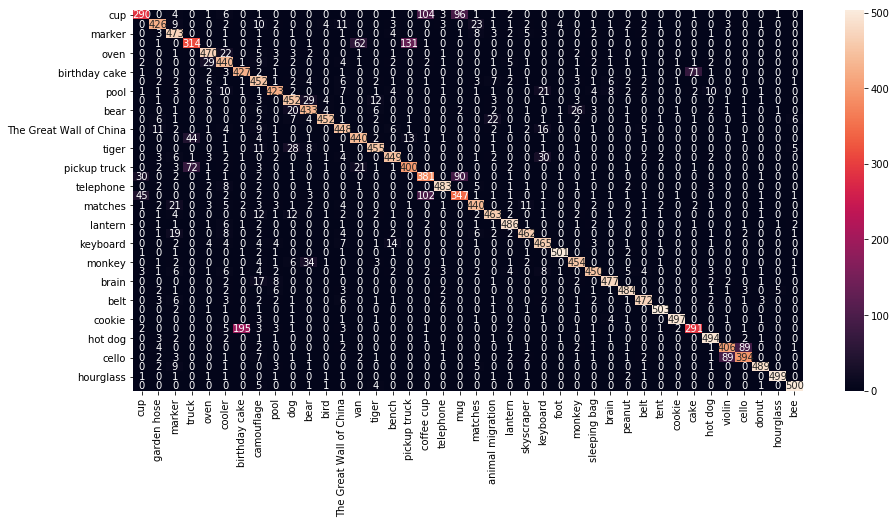

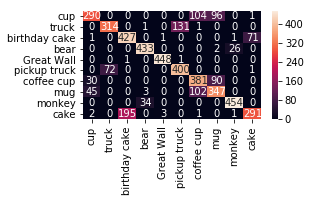

In [17]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

matrix = np.zeros((40,40))
for i,item in enumerate(y_eval_list):
    for j in range(512):
        matrix[i][y_eval_list[i][1][j]] +=1
        #if y_eval_list[i][1][j] != i:
            #print(i,j,y_eval_list[i][1][j])
        
df_cm = pd.DataFrame(matrix, index = [name for name in QD.qd_names],
                  columns = [name for name in QD.qd_names],dtype = np.int16)
plt.figure(figsize = (15,7))
sn.heatmap(df_cm, annot=True, fmt="d")


#Just rename some category for the display.
cat_names =['cup','garden hose', 'marker', 'truck', 'oven', 'cooler', 'birthday cake',
'camouflage', 'pool', 'dog', 'bear','bird', 'Great Wall','van',
'tiger', 'bench', 'pickup truck','coffee cup', 'telephone', 'mug','matches',
'animal migration', 'lantern', 'skyscraper','keyboard','foot','monkey','sleeping bag',
'brain', 'peanut', 'belt', 'tent','cookie', 'cake','hot dog',
'violin', 'cello', 'donut', 'hourglass', 'bee']

#We choose 10 categories to form a confusion matrix
cat = [0,3,6,10,12,16,17,19,26,33]
small = np.zeros((10,10))

l = 0
for i in range(40):
    if i in cat:
        k = 0
        for j in range(40):
            if j in cat:
                small[l][k] = matrix[i][j]
                #print(i,cat_names[j],matrix[i][j])
                k += 1
        l += 1

df_cm = pd.DataFrame(small, index = [cat_names[n] for n in cat],
                  columns = [cat_names[n] for n in cat],dtype = np.int16)
plt.figure(figsize = (4,2))
sn.heatmap(df_cm, annot=True, fmt="d")

In [ ]:
fig,axs = plt.subplots(nrows=1, ncols=3, figsize=(4,2))
img,_,_ = test_data[0*512 + 14]
axs[0].set_title("cup:coffe")
axs[0].imshow(img.reshape(96,96))

img,_,_ = test_data[17*512 + 100]
axs[1].set_title("coffe:mug")
axs[1].imshow(img.reshape(96,96))

img,_,_ = test_data[0*512 + 16]
axs[2].set_title("mug:cup")
axs[2].imshow(img.reshape(96,96))

plt.show()

In [ ]:
fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(3,2))
img,_,_ = test_data[10*512 + 18]
axs[0].set_title("bear:monkey")
axs[0].imshow(img.reshape(96,96))

img,_,_ = test_data[26*512 + 100]
axs[1].set_title("monkey:bear")
axs[1].imshow(img.reshape(96,96))


plt.show()

In [ ]:
fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(3,2))
img,_,_ = test_data[6*512 + 100]
axs[0].set_title("birthday:cake")
axs[0].imshow(img.reshape(96,96))

img,_,_ = test_data[33*512 + 2]
axs[1].set_title("cake:birthday")
axs[1].imshow(img.reshape(96,96))


plt.show()

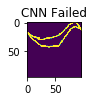

In [16]:
fig,axs = plt.subplots(nrows=1, ncols=1, figsize=(2,1))
img,_,_ = test_data[11*512 + 2]
axs.set_title("CNN Failed")
axs.imshow(img.reshape(96,96))

plt.show()

In [ ]:
args['model'] = 'cnn'
model = cnn_model

model = model.to(device=device)
checkpoint = torch.load("ssn_model_loss_center_89.50")
model.load_state_dict(checkpoint)

class_name = QD.qd_names

class_accuracy = []
center_feature = []
y_list = []

val_accuracy_map1 = AverageMeter()
val_accuracy_map3 = AverageMeter()

for i,name in enumerate(tqdm(class_name)):
    t1 = time.time()
    batch_size = 128
    data_file = os.path.join("./train",name+".csv")
    test_data = QD.QDloadStrokeData(data_file = data_file)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size, num_workers=2, shuffle=False)

    m1,m3,feature_list,y_eval_list = evaluate_test(test_loader,model,args)
    
    if args['model'] != 'rnn':
        feature_list = np.array(feature_list)
        print(feature_list.shape)

        #feature_list is N * 2048
        center_feature.append(np.mean(feature_list,axis = 0))
        
    class_accuracy.append((name,str(m1),str(m3)))
    y_list.extend(y_eval_list)
    
    val_accuracy_map1.update(m1,len(y_eval_list))
    val_accuracy_map3.update(m3,len(y_eval_list))
    
    print(name,str(m1),str(m3))
    t2 = time.time()
    print("Time:",t2-t1)
    
with open('class_accuracy.csv',"w+") as fp:
    writer = csv.writer(fp, delimiter=',')
    writer.writerow(["class", "meanAP1", "meanAP3"])  # write header
    writer.writerows(class_accuracy)

print("The average accuracy %.4f %.4f" % (val_accuracy_map1.avg,val_accuracy_map3.avg))
np.save("y_test_list",y_list)

if args['model'] != 'rnn':
    np.save("center_feature_" + args['model'],center_feature)
    

In [ ]:
torch.save(ssn_model.state_dict(),"ssn_model_0.001")

In [ ]:
if args['model'] == 'cnn':
    np.save("center_feature",center_feature)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
np.save("center_feature_" + args['model'],center_feature)